In [72]:
best_prices = (
    query_data("""
        select
            item,
            expensive_upper as best_price
        from price_reaction_bounds
    """)
)

int(best_prices.pipe(lambda x: x[x['item'] == 'glass_lenses'])['best_price'].values[0])

115

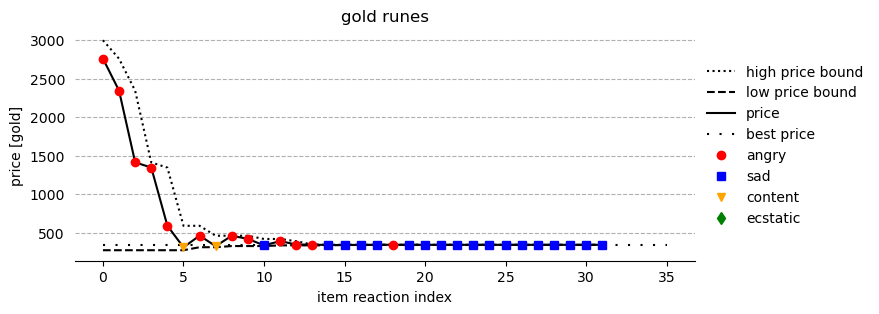

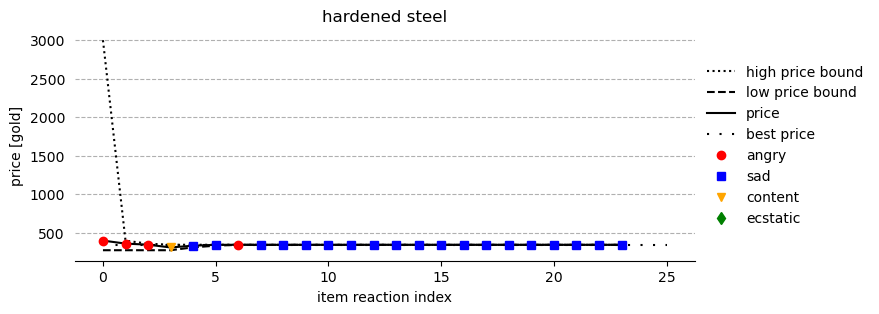

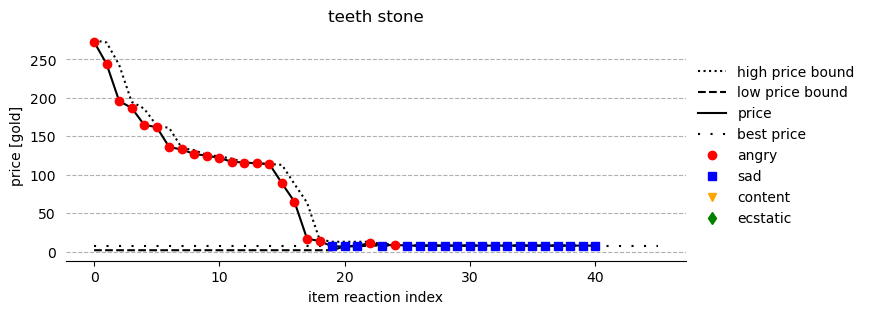

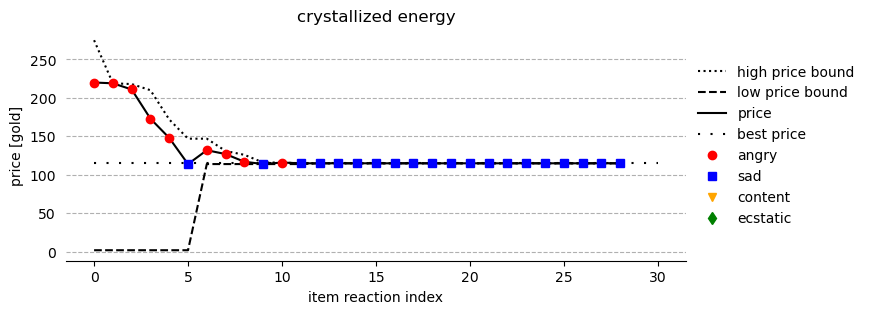

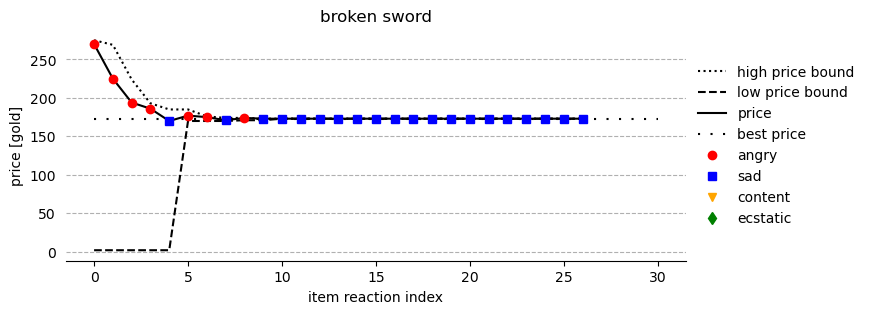

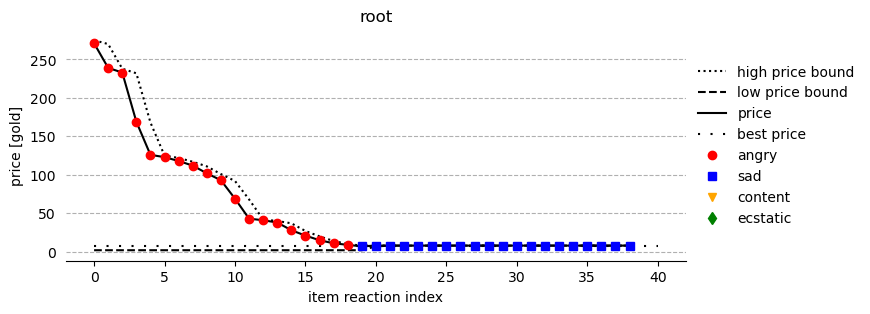

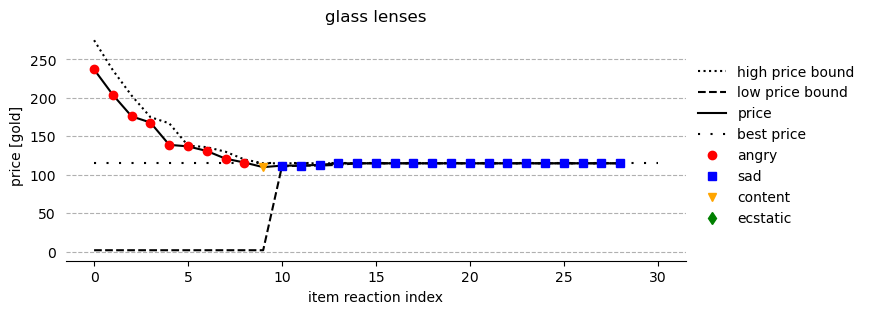

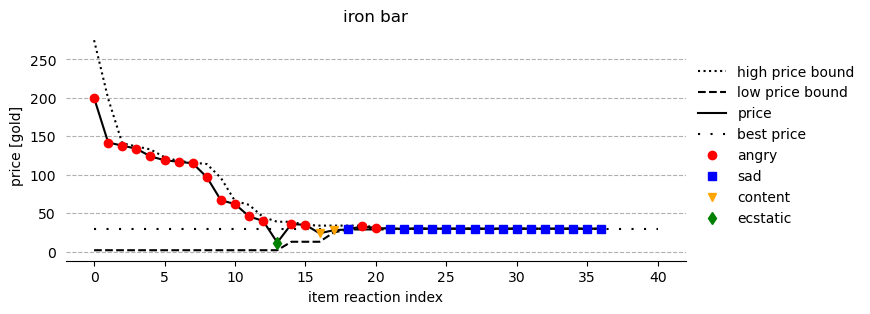

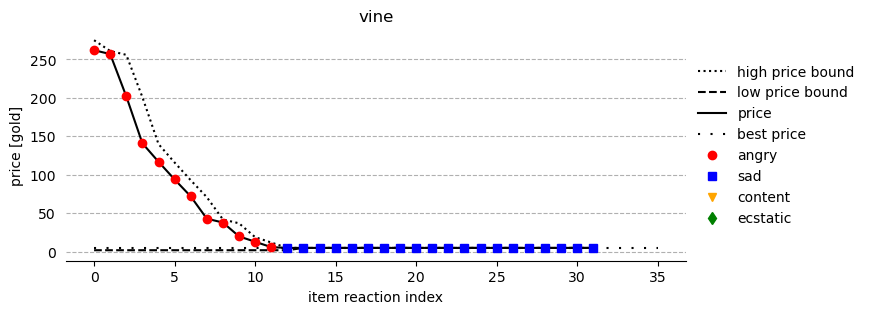

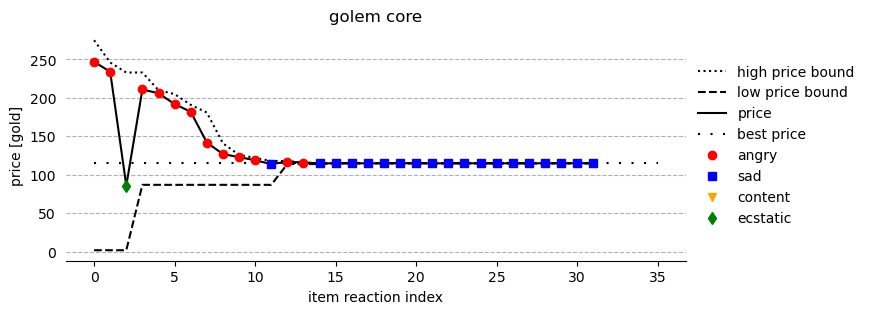

In [87]:
from moonlighter_pricing import query_data
import matplotlib.pylab as plt

prices_and_bounds = (
    query_data("""
        with price_bounds_and_item_insertion_orders as (
            select 
                row_number() over(partition by item) as item_insertion_order,
                * 
            from price_bound_history),
        new_and_old_price_bounds as (
            select
                a.item_insertion_order,
                a.reaction_id,
                a.item,
                a.low,
                a.high,
                b.item_insertion_order as previous_item_insertion_order,
                b.low as previous_low,
                b.high as previous_high
            from price_bounds_and_item_insertion_orders a
            left outer join price_bounds_and_item_insertion_orders b on
                a.item = b.item
                and a.item_insertion_order - 1 = b.item_insertion_order)
        select
            a.shelf_id,
            a.item,
            b.previous_low,
            b.previous_high,
            a.price,
            a.mood,
            b.low,
            b.high            
        from reactions a
        left outer join new_and_old_price_bounds b on
            a.rowid = b.reaction_id"""))
best_prices = (
    query_data("""
        select
            item,
            expensive_upper as best_price
        from price_reaction_bounds
    """)
)
for item in prices_and_bounds['item'].unique():
    fig, ax = plt.subplots(1, 1)
    
    (
        prices_and_bounds
        .pipe(lambda x: x[x['item'] == item])
        .reset_index()
        ['previous_high']
        .plot(
            ax=ax,
            aa=True,
            figsize=(10, 3),
            label='high price bound',
            title=item.replace('_', ' '),
            color='black',
            # linestyle='dashdot',
            style=':',
            # ylim=[0, 3050]
        ))
    (
        prices_and_bounds
        .pipe(lambda x: x[x['item'] == item])
        .reset_index()
        ['previous_low']    
        .plot(
            ax=ax,
            label='low price bound',            
            # linestyle='dashdot',
            style='--',
            color='black',
            ))    
    (
        prices_and_bounds
        .pipe(lambda x: x[x['item'] == item])
        .reset_index()
        ['price']    
        .plot(
            ax=ax,
            
            style='-',
            color='black',
            label='price'))
    (
        ax.hlines(
            int(best_prices.pipe(lambda x: x[x['item'] == item])['best_price'].values[0]), 
            0,
            # ax.get_xticks().min(), 
            ax.get_xticks().max(), 
            # linestyle='densely dashdotted', 
            # linestyle=(0, (3, 5, 1, 5)),
            linestyle=(0, (1, 5)),
            color='black',
            label='best price'
        )
    )
    (
        prices_and_bounds
        .pipe(lambda x: x[x['item'] == item])
        .reset_index()
        .pipe(lambda x: x[x['mood'] == 'angry'])
        ['price']
        .plot(
            ax=ax,
            
            label='angry',
            color='red',
            style='o'))
    (
        prices_and_bounds
        .pipe(lambda x: x[x['item'] == item])
        .reset_index()
        .pipe(lambda x: x[x['mood'] == 'sad'])
        ['price']
        .plot(
            ax=ax,
            
            label='sad',
            color='blue',
            style='s'))
    (
        prices_and_bounds
        .pipe(lambda x: x[x['item'] == item])
        .reset_index()
        .pipe(lambda x: x[x['mood'] == 'content'])
        ['price']
        .plot(
            ax=ax,
            
            label='content',
            color='orange',
            style='v'))
    (
        prices_and_bounds
        .pipe(lambda x: x[x['item'] == item])
        .reset_index()
        .pipe(lambda x: x[x['mood'] == 'ecstatic'])
        ['price']
        .plot(
            ax=ax,
            
            label='ecstatic',
            color='green',
            style='d'))
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    plt.tick_params(left = False) 
    ax.grid(axis='y', linestyle='--')
    plt.xlabel('item reaction index')
    plt.ylabel('price [gold]')
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    ax.legend(
        frameon=False, 
        loc='center left', 
        bbox_to_anchor=(1, 0.5))

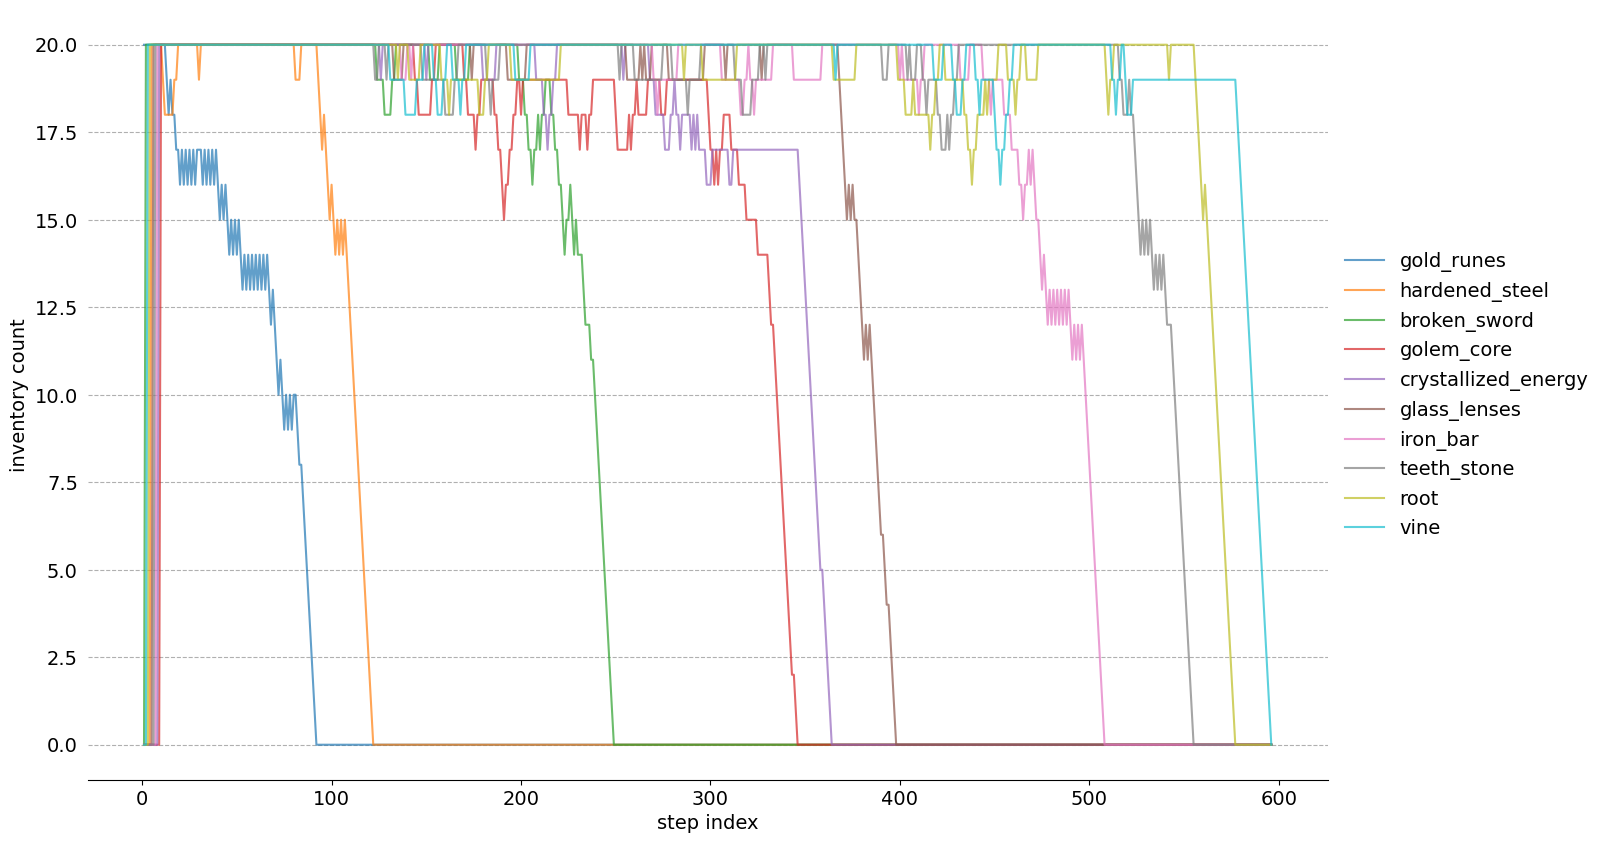

In [92]:
fig, ax = plt.subplots(1, 1)
fontsize = 14
(
    query_data("""
        select 
            rowid,
            * 
        from inventory_changes        
    """)
    .pivot(
        index='rowid',
        columns='item',
        values='change')
    .fillna(0)
    .cumsum()
    [[
        'gold_runes', 'hardened_steel', 'broken_sword', 'golem_core',
        'crystallized_energy', 'glass_lenses', 'iron_bar', 'teeth_stone', 
        'root', 'vine']]
    .plot(
        fontsize=fontsize,
        ax=ax,
        alpha=0.7,
        aa=True,
        figsize=(20, 10)))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.tick_params(left = False) 
ax.grid(axis='y', linestyle='--')
plt.xlabel('step index', fontsize=fontsize)
plt.ylabel('inventory count', fontsize=fontsize)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(
    fontsize=fontsize,
    frameon=False, 
    loc='center left', 
    bbox_to_anchor=(1, 0.5))
fig.savefig(
    'item_inventory_counts.webp', 
    format='webp', 
    # dpi=1
)

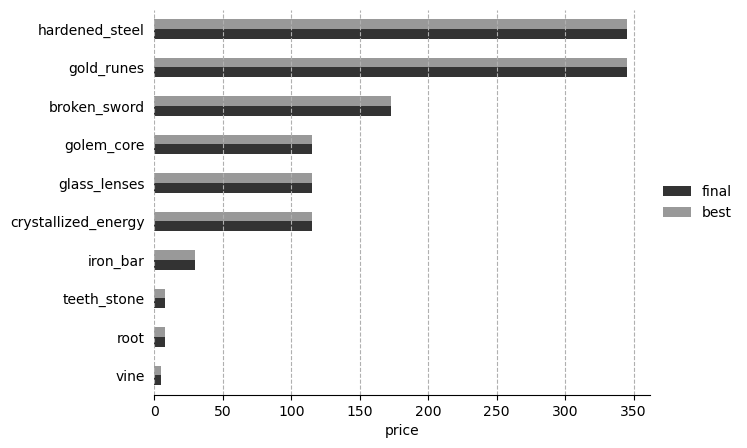

In [65]:
ax = (
    prices_and_bounds
    .groupby(
        'item', 
        # include_groups=False
        # include_groups=False
    )
    .apply(
        lambda x: (
            x            
            .tail(1)
            ['price']
            .values[0]),
        include_groups=False
    )
    .reset_index()    
    .rename(columns={0: 'final_price'})
    .merge(
        (
            query_data("""
                select
                    item,
                    expensive_upper as best_price
                from price_reaction_bounds
            """)
        ),
        on='item',
        how='left'
    )
    .set_index('item')
    .sort_values('final_price')
    .rename(columns={'final_price': 'final', 'best_price': 'best'})
    .plot.barh(
        
        color=['black', 'grey'],
        alpha=0.8, 
        aa=True, 
        figsize=(8, 5))
    
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.tick_params(left = False) 
ax.grid(axis='x', linestyle='--')
plt.xlabel('price')
plt.ylabel('')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
_ = ax.legend(
    frameon=False, 
    loc='center left', 
    bbox_to_anchor=(1, 0.5))